## Canada - Temporary Foreign Worker Program work permit holders by province/territory of intended destination, intended occupation (4-digit NOC 2011) and year in which permit(s) became effective
www.cic.gc.ca/opendata-donneesouvertes/data/IRCC_M_TR_0009_E.xls

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
datapath = Path(".//data")
#[x for x in datapath.iterdir() if x.is_file()]

In [3]:
d = pd.read_excel(datapath.joinpath("IRCC_M_TR_0009_E.xls"))

In [4]:
# Column labels
YR = []
for h in d.iloc[1].values:
    if str(h).isdigit():
        for i in range(17):
            YR.append(int(h))

TM = d.loc[3][2:].values
YR = YR[:len(TM)]

col_labels = [(str(t) + "_" + str(y)).replace('Total_','').replace('nan_', '').replace(' ','_') for t, y in zip(TM,YR)]
col_labels[:4]

['Jan_2015', 'Feb_2015', 'Mar_2015', 'Q1_2015']

In [5]:
# Row Indexs
# Geo Labels
labels = []
counts = []
last = -1
for i, lbl in zip(d.index, d.iloc[4:2703,0]):
    if str(lbl) != 'nan':
        labels.append(lbl)
        counts.append(i - last)
        last = i
geo = []
for lbl, cnt in zip(labels, counts):
    for i in range(cnt):
        geo.append(lbl.replace('Total','').strip())

# NOC Labels
nocs_desc = d.iloc[4:2703,1].values
nocs_desc = [str(noc_desc).replace('nan','All') for noc_desc in nocs_desc]
nocs = []
desc = []
for txt in nocs_desc:
    if txt[0].isdigit():
        nocs.append(txt[:4])
        desc.append(txt[6:].strip())
    else: 
        if txt == 'Other occupations':
            nocs.append('OTRO')
        elif txt == 'Occupation not stated':
            nocs.append('UNKN')
        else:
            nocs.append('ALLO')
        desc.append(txt.strip())

# NOC description lookup
df_tmp = pd.DataFrame({"noc":nocs, "description": desc})
df_NOC_description = df_tmp.groupby('noc').last()
df_NOC_description.head()

,description
noc,
0011,Legislators
0012,Senior government managers and officials
0013,"Senior managers - fiAllcial, communications an..."
0014,"Senior managers - health, education, social an..."
0015,"Senior managers - trade, broadcasting and othe..."


In [6]:
# Content
df = d.iloc[4:2703,2:len(col_labels)+3]
df.columns = col_labels
df['geo'] = geo
df['noc'] = nocs
df = df.set_index(['geo','noc']).apply(pd.to_numeric, errors='coerce').fillna(0).reset_index()
df.tail(2)

,geo,noc,Jan_2015,Feb_2015,Mar_2015,Q1_2015,Apr_2015,May_2015,Jun_2015,Q2_2015,...,Sep_2019,Q3_2019,Oct_2019,Nov_2019,Dec_2019,Q4_2019,2019,Jan_2020,Q1_2020,2020
2697,Province/territory not stated,ALLO,0.0,0.0,40.0,45.0,90.0,185.0,610.0,890.0,...,60.0,165.0,20.0,20.0,30.0,70.0,325.0,15.0,15.0,15.0
2698,,ALLO,5780.0,4620.0,8185.0,18510.0,12415.0,9085.0,9215.0,30615.0,...,6325.0,23240.0,5295.0,5650.0,4980.0,15900.0,98390.0,7605.0,7605.0,7605.0


In [7]:
# reshape
df_wpcnt = df.melt(id_vars=["geo","noc"], 
        var_name="duration", 
        value_name="wp_cnt")

# duration to month, year
YR = []
duration = []
dur_type = []
for d in df_wpcnt.duration:
    s = d.split('_')
    if len(s) > 1:
        YR.append(int(s[1]))
        duration.append(s[0])
        if s[0][0] == 'Q':
            dur_type.append('Q')
        else:
            dur_type.append('M')
    else:
        YR.append(d)
        duration.append('')
        dur_type.append('A')

df_wpcnt['YR'] = YR
df_wpcnt['duration'] = duration
df_wpcnt['dur_type'] = dur_type
df_wpcnt = df_wpcnt.set_index(['geo','noc','YR','duration','dur_type']).reset_index()
df_wpcnt.head()


,geo,noc,YR,duration,dur_type,wp_cnt
0,Newfoundland and Labrador,0013,2015,Jan,M,0.0
1,Newfoundland and Labrador,0016,2015,Jan,M,0.0
2,Newfoundland and Labrador,0112,2015,Jan,M,0.0
3,Newfoundland and Labrador,0114,2015,Jan,M,0.0
4,Newfoundland and Labrador,0124,2015,Jan,M,0.0


### included NOC for agri 

0821 - Managers in agriculture
0822 - Managers in horticulture
0823 - Managers in aquaculture
2123 - Agricultural representatives, consultants and specialists
2222 - Agricultural and fish products inspectors
8252 - Agricultural service contractors, farm supervisors and specialized livestock workers
8431 - General farm workers
8432 - Nursery and greenhouse workers
8611 - Harvesting labourers
8613 – Aquaculture and marine harvest labourers
9213 - Supervisors, food, beverage and associated products processing
9461 - Process control and machine operators, food, beverage and associated products processing
9462 - Industrial butchers and meat cutters, poultry preparers and related workers
9463 - Fish and seafood plant workers
9465 – Testers and graders, food, beverage and associated products processing
9617 - Labourers in food, beverage and associated products processing
9618 - Labourers in fish and seafood processing

In [8]:
filter_Agri = ['0821','0822', '0823', '2123', '2222', 
               '8252', '8431', '8432', '8611', '8613', '9213', 
               '9461', '9462', '9463', '9465', '9617', '9618']

### Canada  

In [17]:
df_agri = df_wpcnt[(df_wpcnt.noc.isin(filter_Agri)) & (df_wpcnt.dur_type == 'M')]
df_agri_cnt = df_agri[['YR','duration','wp_cnt']].groupby(['YR','duration']).sum()
df_agri_cnt.reset_index(inplace=True)
combined =  "15 " + df_agri_cnt.duration + " " + df_agri_cnt.YR.astype(str)
df_agri_cnt['time'] = pd.to_datetime(combined, format ='%d %b %Y')
df_agri_cnt.set_index("time", inplace=True)

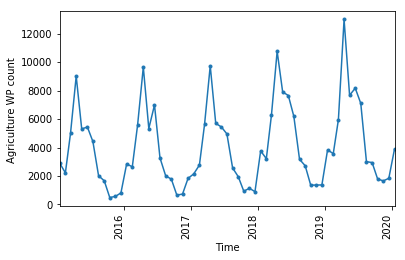

In [18]:
import matplotlib.pyplot as plt
g = df_agri_cnt
ax = g.wp_cnt.plot.line(marker=".", rot=90)
ax.set_ylabel("Agriculture WP count ")
ax.set_xlabel("Time")

plt.show()

### Province

In [11]:
df_agri = df_wpcnt[(df_wpcnt.noc.isin(filter_Agri)) & (df_wpcnt.dur_type == 'M')]
df_agri_cnt = df_agri[['geo', 'YR','duration','wp_cnt']].groupby(['geo','YR','duration']).sum()
df_agri_cnt.reset_index(inplace=True)
combined =  "15 " + df_agri_cnt.duration + " " + df_agri_cnt.YR.astype(str)
df_agri_cnt['time'] = pd.to_datetime(combined, format ='%d %b %Y')
df_agri_cnt.set_index("time", inplace=True)
df_agri_cnt.geo.unique()

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Saskatchewan'], dtype=object)

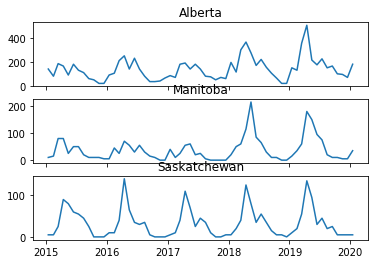

In [12]:
includedProv = ['Alberta', 'Manitoba', 'Saskatchewan']
df = df_agri_cnt[df_agri_cnt.geo.isin(includedProv)]
grouped = df.groupby('geo')
nrows = grouped.ngroups
fig, axs = plt.subplots(nrows = nrows, ncols = 1, sharex = True)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key).sort_values(by=['time'])['wp_cnt'])
    ax.set_title(str(key))
plt.show()

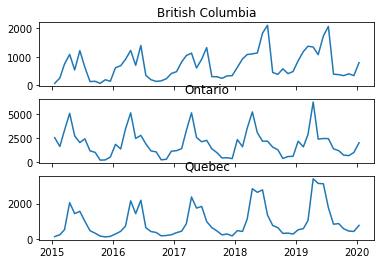

In [13]:
includedProv = ['Quebec', 'Ontario', 'British Columbia']
df = df_agri_cnt[df_agri_cnt.geo.isin(includedProv)]
grouped = df.groupby('geo')
nrows = grouped.ngroups
fig, axs = plt.subplots(nrows = nrows, ncols = 1, sharex = True)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key).sort_values(by=['time'])['wp_cnt'])
    ax.set_title(str(key))
plt.show()

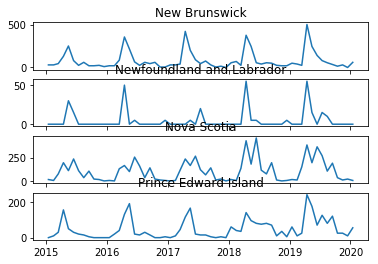

In [14]:
includedProv = ['New Brunswick', 'Nova Scotia', 'Prince Edward Island', 'Newfoundland and Labrador']
df = df_agri_cnt[df_agri_cnt.geo.isin(includedProv)]
grouped = df.groupby('geo')
nrows = grouped.ngroups
fig, axs = plt.subplots(nrows = nrows, ncols = 1, sharex = True)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key).sort_values(by=['time'])['wp_cnt'])
    ax.set_title(str(key))
plt.show()

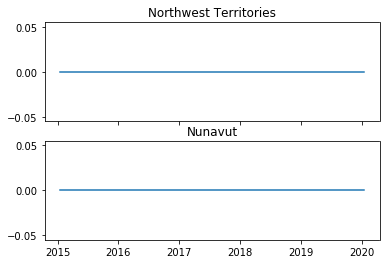

In [15]:
includedProv = ['Yukon', 'Nunavut', 'Northwest Territories']
df = df_agri_cnt[df_agri_cnt.geo.isin(includedProv)]
grouped = df.groupby('geo')
nrows = grouped.ngroups
fig, axs = plt.subplots(nrows = nrows, ncols = 1, sharex = True)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key).sort_values(by=['time'])['wp_cnt'])
    ax.set_title(str(key))
plt.show()